In [143]:
import pandas as pd
import numpy as np
import sqlite3
from sqlite3 import Error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

## CREAMOS CONEXION A BASE DE DATOS

In [144]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print('Conexión a BD SQLite satisfactoriamente')
        connection.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(f"Error: '{e}'")

    return connection

In [145]:
bbdd = 'Base_datos_estadisticas_basket.db'
connection = create_connection(bbdd)

Conexión a BD SQLite satisfactoriamente


## CARGAMOS DATAFRAMES DIRECTAMENTE DE LA BASE DE DATOS

In [146]:
player_id = int(input('Introduce el ID del jugador: '))
df_player_stats = pd.read_sql_query(f'SELECT * from ESTADISTICAS_PARTIDO_JUGADORES WHERE IDJugador = {player_id}', connection)
df_games_stats = pd.read_sql_query('SELECT * from PARTIDOS', connection)
df_games_played = pd.read_sql_query(f'SELECT * from PARTIDOS_DISPUTADOS WHERE IDJugador = {player_id}', connection)   

In [147]:
display(df_player_stats.sample(5))
df_player_stats.info()

,IDPartido,IDJugador,Minutos,Puntos,Tiros 3 intentados,Tiros 3 conseguidos,Tiros 2 intentados,Tiros 2 conseguidos,Tiros libres intentados,Tiros libres conseguidos,Asistencias,Robos,Perdidas,Rebotes ofensivos,Rebotes defensivos,Tapones,Faltas
451,128054,246,37,20,2,1,16,8,2,1,8,0,7,2,10,0,2
312,49151,246,37,29,7,1,19,12,2,2,2,3,4,3,11,0,4
87,30003,246,22:06,8,1,0,6,4,0,0,2,1,1,1,4,1,2
77,29343,246,23:55,2,2,0,5,1,0,0,2,2,3,0,8,0,2
571,474567,246,43,38,2,0,19,14,12,10,8,1,4,5,14,0,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   IDPartido                 662 non-null    int64 
 1   IDJugador                 662 non-null    int64 
 2   Minutos                   662 non-null    object
 3   Puntos                    662 non-null    int64 
 4   Tiros 3 intentados        662 non-null    int64 
 5   Tiros 3 conseguidos       662 non-null    int64 
 6   Tiros 2 intentados        662 non-null    int64 
 7   Tiros 2 conseguidos       662 non-null    int64 
 8   Tiros libres intentados   662 non-null    int64 
 9   Tiros libres conseguidos  662 non-null    int64 
 10  Asistencias               662 non-null    int64 
 11  Robos                     662 non-null    int64 
 12  Perdidas                  662 non-null    int64 
 13  Rebotes ofensivos         662 non-null    int64 
 14  Rebotes defensivos        

In [148]:
display(df_games_stats.sample(5))
df_games_stats.info()

,IDPartido,Fecha,IDEquipo local,Nombre equipo local,Puntos equipo local,IDEquipo visitante,Nombre equipo visitante,Puntos equipo visitante
500,473421,2021-10-20 00:00:00 UTC,24,Phoenix Suns,98,8,Denver Nuggets,110
556,474322,2022-02-27 00:00:00 UTC,25,Portland Trail Blazers,92,8,Denver Nuggets,124
348,62952,2019-12-12 00:00:00 UTC,8,Denver Nuggets,114,25,Portland Trail Blazers,99
33,533,2018-12-29 00:00:00 UTC,24,Phoenix Suns,118,8,Denver Nuggets,122
314,60497,2019-04-16 00:00:00 UTC,8,Denver Nuggets,114,27,San Antonio Spurs,105


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   IDPartido                662 non-null    int64 
 1   Fecha                    662 non-null    object
 2   IDEquipo local           662 non-null    int64 
 3   Nombre equipo local      662 non-null    object
 4   Puntos equipo local      662 non-null    int64 
 5   IDEquipo visitante       662 non-null    int64 
 6   Nombre equipo visitante  662 non-null    object
 7   Puntos equipo visitante  662 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 41.5+ KB


In [149]:
display(df_games_played.sample(5))
df_games_played.info()

,IDJugador,IDPartido,IDEquipo jugador,Temporada
91,246,30428,8,2015
330,246,62650,8,2019
444,246,127951,8,2020
337,246,62769,8,2019
39,246,618,8,2018


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   IDJugador         662 non-null    int64
 1   IDPartido         662 non-null    int64
 2   IDEquipo jugador  662 non-null    int64
 3   Temporada         662 non-null    int64
dtypes: int64(4)
memory usage: 20.8 KB


## UNIMOS DATAFRAMES PARA POSTERIOR ESTUDIO

In [150]:
df_merge_games_stats = pd.merge(left=df_games_played, right=df_games_stats, how='inner', on=['IDPartido'])
display(df_merge_games_stats.sample(5))

,IDJugador,IDPartido,IDEquipo jugador,Temporada,Fecha,IDEquipo local,Nombre equipo local,Puntos equipo local,IDEquipo visitante,Nombre equipo visitante,Puntos equipo visitante
655,246,858500,8,2022,2023-03-30 00:00:00 UTC,8,Denver Nuggets,88,19,New Orleans Pelicans,107
505,246,473492,8,2021,2021-10-30 00:00:00 UTC,18,Minnesota Timberwolves,91,8,Denver Nuggets,93
525,246,473859,8,2021,2021-12-19 00:00:00 UTC,3,Brooklyn Nets,118,8,Denver Nuggets,124
532,246,473961,8,2021,2022-01-03 00:00:00 UTC,7,Dallas Mavericks,103,8,Denver Nuggets,89
395,246,110967,8,2019,2020-08-08 00:00:00 UTC,8,Denver Nuggets,134,29,Utah Jazz,132


## TRATAMOS DATOS PARA OBTENER DATAFRAME DE ENTRENAMIENTO

In [151]:
df_player_stats['Rebotes'] = df_player_stats['Rebotes ofensivos'] + df_player_stats['Rebotes defensivos']
display(df_player_stats.sample(5))

,IDPartido,IDJugador,Minutos,Puntos,Tiros 3 intentados,Tiros 3 conseguidos,Tiros 2 intentados,Tiros 2 conseguidos,Tiros libres intentados,Tiros libres conseguidos,Asistencias,Robos,Perdidas,Rebotes ofensivos,Rebotes defensivos,Tapones,Faltas,Rebotes
285,48280,246,33:48,25,3,1,10,7,10,8,10,1,2,2,12,1,3,14
78,29417,246,18:17,4,0,0,3,2,0,0,0,3,0,2,4,0,3,6
548,474212,246,30,27,2,0,13,12,4,3,10,2,2,1,11,1,1,12
442,127934,246,38,43,5,3,18,13,8,8,5,2,3,3,3,1,3,6
57,28067,246,15:45,6,1,0,5,3,0,0,2,3,1,3,4,0,4,7


In [152]:
df_merge_games_stats['Resultado'] = np.nan
df_merge_games_stats['Puntos diferencia'] = np.nan

In [153]:
for row in list(range(len(df_merge_games_stats))):
    if (df_merge_games_stats['IDEquipo jugador'][row] == df_merge_games_stats['IDEquipo local'][row]) and (df_merge_games_stats['Puntos equipo local'][row] > df_merge_games_stats['Puntos equipo visitante'][row]):
        df_merge_games_stats['Resultado'][row] = 'G'
        df_merge_games_stats['Puntos diferencia'][row] = int(df_merge_games_stats['Puntos equipo local'][row]) - int(df_merge_games_stats['Puntos equipo visitante'][row])
    else: 
        if (df_merge_games_stats['IDEquipo jugador'][row] == df_merge_games_stats['IDEquipo visitante'][row]) and (df_merge_games_stats['Puntos equipo visitante'][row] > df_merge_games_stats['Puntos equipo local'][row]):
            df_merge_games_stats['Resultado'][row] = 'G'
            df_merge_games_stats['Puntos diferencia'][row] = int(df_merge_games_stats['Puntos equipo visitante'][row]) - int(df_merge_games_stats['Puntos equipo local'][row])

        else:
            df_merge_games_stats['Resultado'][row] = 'P'
            if df_merge_games_stats['Puntos equipo visitante'][row] > df_merge_games_stats['Puntos equipo local'][row]:
                df_merge_games_stats['Puntos diferencia'][row] = int(df_merge_games_stats['Puntos equipo local'][row]) - int(df_merge_games_stats['Puntos equipo visitante'][row])
            else: df_merge_games_stats['Puntos diferencia'][row] = int(df_merge_games_stats['Puntos equipo visitante'][row]) - int(df_merge_games_stats['Puntos equipo local'][row])


/var/folders/c4/_ypb5q951fd_yh59zyczqrvm0000gn/T/ipykernel_65627/667673077.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_games_stats['Resultado'][row] = 'G'
/var/folders/c4/_ypb5q951fd_yh59zyczqrvm0000gn/T/ipykernel_65627/667673077.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_games_stats['Puntos diferencia'][row] = int(df_merge_games_stats['Puntos equipo visitante'][row]) - int(df_merge_games_stats['Puntos equipo local'][row])
/var/folders/c4/_ypb5q951fd_yh59zyczqrvm0000gn/T/ipykernel_65627/667673077.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [154]:
display(df_merge_games_stats.sample(5))
df_merge_games_stats.info()

,IDJugador,IDPartido,IDEquipo jugador,Temporada,Fecha,IDEquipo local,Nombre equipo local,Puntos equipo local,IDEquipo visitante,Nombre equipo visitante,Puntos equipo visitante,Resultado,Puntos diferencia
280,246,46993,8,2018,2019-01-28 00:00:00 UTC,15,Memphis Grizzlies,92,8,Denver Nuggets,95,G,3.0
424,246,127622,8,2020,2021-01-07 00:00:00 UTC,8,Denver Nuggets,117,7,Dallas Mavericks,124,P,-7.0
590,246,857517,8,2022,2022-11-09 00:00:00 UTC,12,Indiana Pacers,119,8,Denver Nuggets,122,G,3.0
383,246,63443,8,2019,2020-02-25 00:00:00 UTC,8,Denver Nuggets,115,9,Detroit Pistons,98,G,17.0
190,246,34202,8,2016,2017-01-22 00:00:00 UTC,18,Minnesota Timberwolves,111,8,Denver Nuggets,108,P,-3.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   IDJugador                662 non-null    int64  
 1   IDPartido                662 non-null    int64  
 2   IDEquipo jugador         662 non-null    int64  
 3   Temporada                662 non-null    int64  
 4   Fecha                    662 non-null    object 
 5   IDEquipo local           662 non-null    int64  
 6   Nombre equipo local      662 non-null    object 
 7   Puntos equipo local      662 non-null    int64  
 8   IDEquipo visitante       662 non-null    int64  
 9   Nombre equipo visitante  662 non-null    object 
 10  Puntos equipo visitante  662 non-null    int64  
 11  Resultado                662 non-null    object 
 12  Puntos diferencia        662 non-null    float64
dtypes: float64(1), int64(8), object(4)
memory usage: 67.4+ KB


In [155]:
def drop_columns(data, columns):
    '''
    Función que elimina dado un dataframe las columnas indicadas en una lista
    Input:
        - data: pandas dataframe
        - columns: lista
    Output: pandas dataframe
    '''
    data.drop(columns, axis=1, inplace=True)
    return

In [156]:
columns_to_drop = ['IDEquipo jugador', 'Temporada', 'Fecha', 'IDEquipo local', 'Nombre equipo local', 'Puntos equipo local', 'IDEquipo visitante', 'Nombre equipo visitante', 'Puntos equipo visitante']
drop_columns(df_merge_games_stats, columns_to_drop)
display(df_merge_games_stats.sample(5))

,IDJugador,IDPartido,Resultado,Puntos diferencia
247,246,35212,G,3.0
606,246,857768,G,13.0
163,246,33704,P,-4.0
153,246,33523,G,8.0
516,246,473728,P,-5.0


In [157]:
df_merge_player_stats = pd.merge(left=df_player_stats, right=df_merge_games_stats, how='inner', on=['IDJugador','IDPartido'])
display(df_merge_player_stats.sample(5))

,IDPartido,IDJugador,Minutos,Puntos,Tiros 3 intentados,Tiros 3 conseguidos,Tiros 2 intentados,Tiros 2 conseguidos,Tiros libres intentados,Tiros libres conseguidos,Asistencias,Robos,Perdidas,Rebotes ofensivos,Rebotes defensivos,Tapones,Faltas,Rebotes,Resultado,Puntos diferencia
230,34935,246,30:43,14,2,1,12,3,6,5,4,1,2,3,4,1,4,7,P,-19.0
607,857783,246,35,25,3,1,12,7,9,8,8,4,5,2,9,0,3,11,P,-18.0
517,473751,246,27,32,7,3,12,11,1,1,5,0,4,3,8,0,0,11,G,14.0
111,32439,246,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,G,3.0
228,34922,246,47:31,34,5,4,17,8,6,6,3,1,5,5,10,0,5,15,P,-8.0


In [158]:
def minutes_to_number(data):
    '''
    Función para transformar la columna Minutos de tipo object a tipo int
    Input: pandas dataframe
    Output: pandas dataframe
    '''
    data['Minutos'] = data['Minutos'].apply(lambda x: np.nan if x == '' else float(x.split(':')[0]))
    return

In [159]:
minutes_to_number(df_merge_player_stats)
display(df_merge_player_stats.sample(5))
df_merge_player_stats.info()

,IDPartido,IDJugador,Minutos,Puntos,Tiros 3 intentados,Tiros 3 conseguidos,Tiros 2 intentados,Tiros 2 conseguidos,Tiros libres intentados,Tiros libres conseguidos,Asistencias,Robos,Perdidas,Rebotes ofensivos,Rebotes defensivos,Tapones,Faltas,Rebotes,Resultado,Puntos diferencia
406,120810,246,30.0,15,2,0,12,6,4,3,3,0,1,1,2,0,2,3,P,-23.0
622,858004,246,35.0,17,4,1,7,7,0,0,14,2,4,0,10,1,3,10,G,3.0
250,35255,246,27.0,17,0,0,10,6,7,5,1,0,4,7,4,1,1,11,P,-7.0
458,264319,246,29.0,12,0,0,7,6,0,0,10,0,3,2,8,0,2,10,G,25.0
33,533,246,37.0,23,2,0,9,8,8,7,9,3,4,1,7,1,3,8,G,4.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   IDPartido                 662 non-null    int64  
 1   IDJugador                 662 non-null    int64  
 2   Minutos                   661 non-null    float64
 3   Puntos                    662 non-null    int64  
 4   Tiros 3 intentados        662 non-null    int64  
 5   Tiros 3 conseguidos       662 non-null    int64  
 6   Tiros 2 intentados        662 non-null    int64  
 7   Tiros 2 conseguidos       662 non-null    int64  
 8   Tiros libres intentados   662 non-null    int64  
 9   Tiros libres conseguidos  662 non-null    int64  
 10  Asistencias               662 non-null    int64  
 11  Robos                     662 non-null    int64  
 12  Perdidas                  662 non-null    int64  
 13  Rebotes ofensivos         662 non-null    int64  
 14  Rebotes de

In [160]:
df_merge_player_stats.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)
df_merge_player_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   IDPartido                 662 non-null    int64  
 1   IDJugador                 662 non-null    int64  
 2   Minutos                   662 non-null    float64
 3   Puntos                    662 non-null    int64  
 4   Tiros 3 intentados        662 non-null    int64  
 5   Tiros 3 conseguidos       662 non-null    int64  
 6   Tiros 2 intentados        662 non-null    int64  
 7   Tiros 2 conseguidos       662 non-null    int64  
 8   Tiros libres intentados   662 non-null    int64  
 9   Tiros libres conseguidos  662 non-null    int64  
 10  Asistencias               662 non-null    int64  
 11  Robos                     662 non-null    int64  
 12  Perdidas                  662 non-null    int64  
 13  Rebotes ofensivos         662 non-null    int64  
 14  Rebotes de

## ELIMINAMOS COLUMNAS QUE NO NOS SIRVEN PARA EL ANALISIS

In [161]:
columns_to_drop = ['IDPartido', 'IDJugador', 'Tiros 3 intentados','Tiros 3 conseguidos', 'Tiros 2 intentados','Tiros 2 conseguidos','Tiros libres intentados', 'Tiros libres conseguidos', 'Rebotes ofensivos', 'Rebotes defensivos']
drop_columns(df_merge_player_stats, columns_to_drop)
display(df_merge_player_stats.sample(5))

,Minutos,Puntos,Asistencias,Robos,Perdidas,Tapones,Faltas,Rebotes,Resultado,Puntos diferencia
571,43.0,38,8,1,4,0,2,19,P,-6.0
173,21.0,5,2,0,4,0,4,7,G,5.0
432,34.0,21,3,0,1,1,2,11,G,27.0
161,29.0,23,5,2,7,0,1,12,G,16.0
372,39.0,25,5,0,8,1,3,13,P,-8.0


## GRAFICAMOS PARA VER RELACIONES

#### RELACION LINEAL CON LOS PUNTOS DE DIFERENCIA EN PARTIDOS GANADOS O PERDIDOS

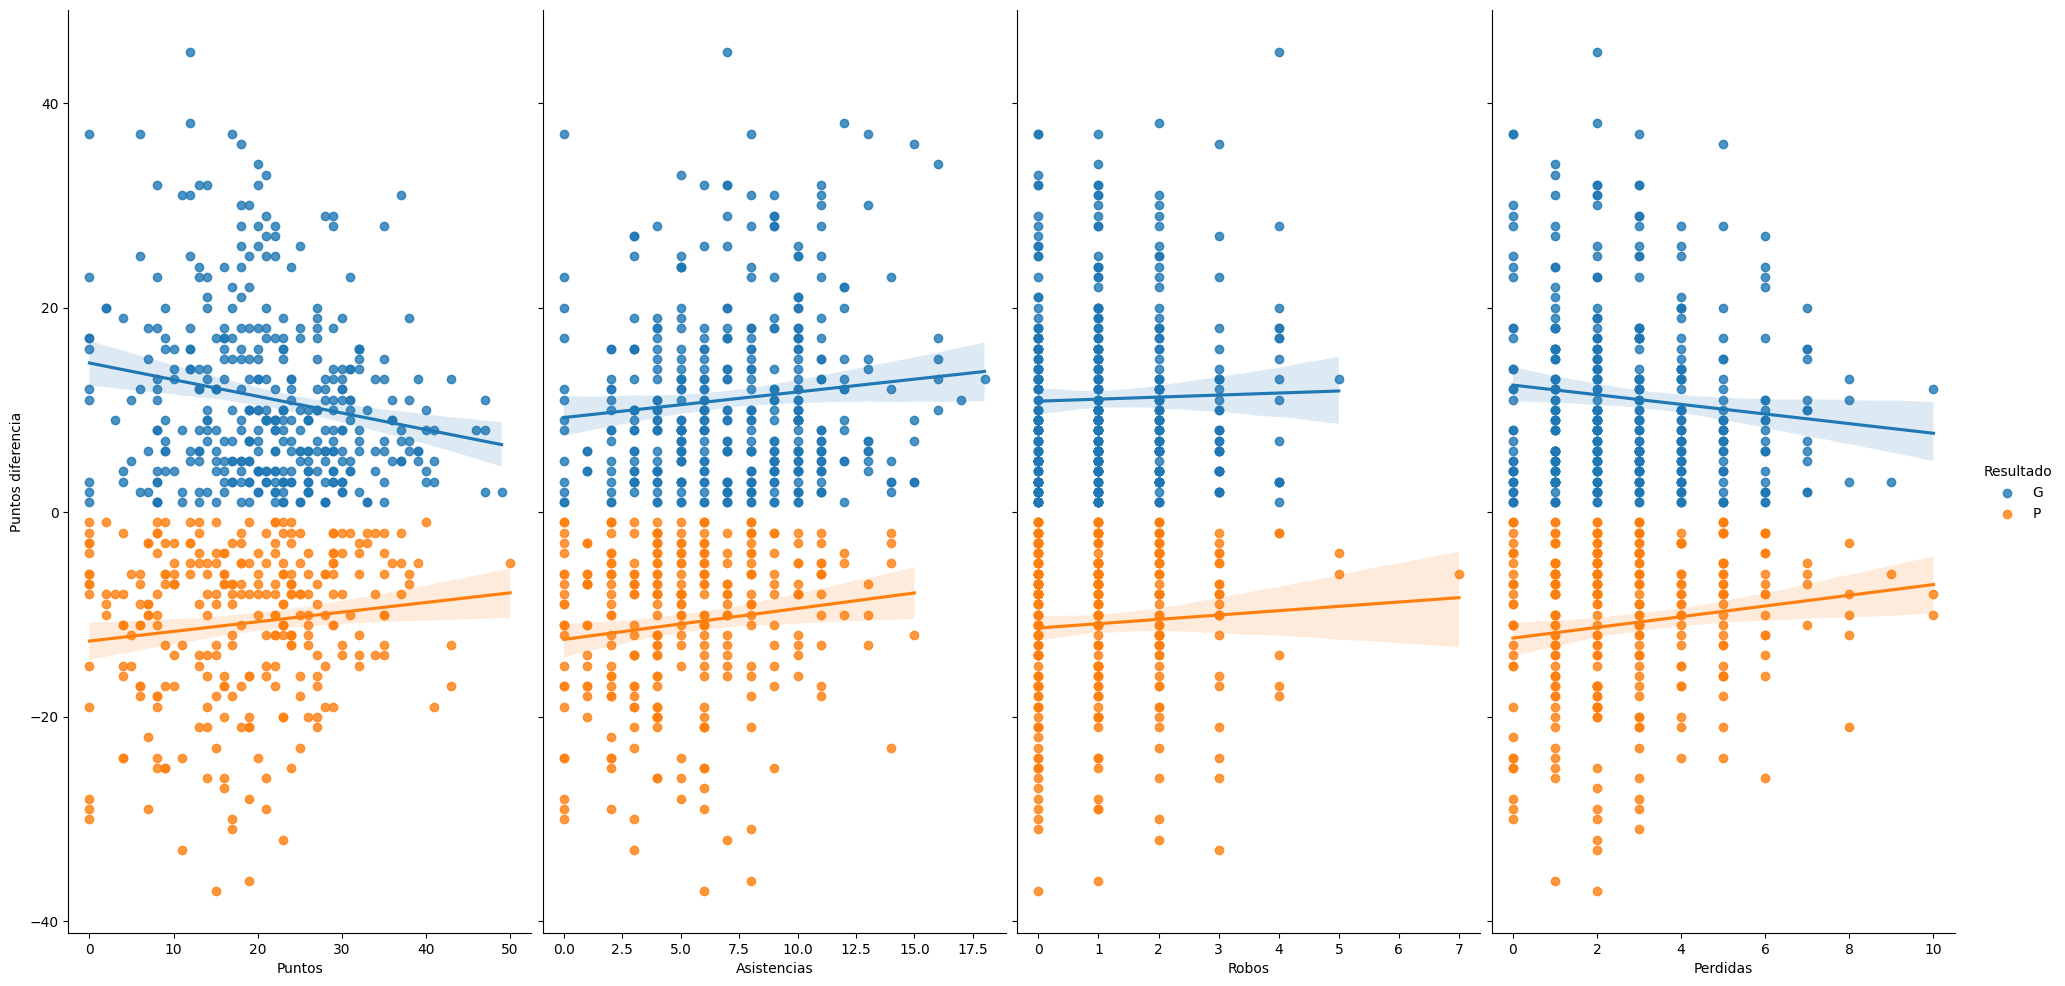

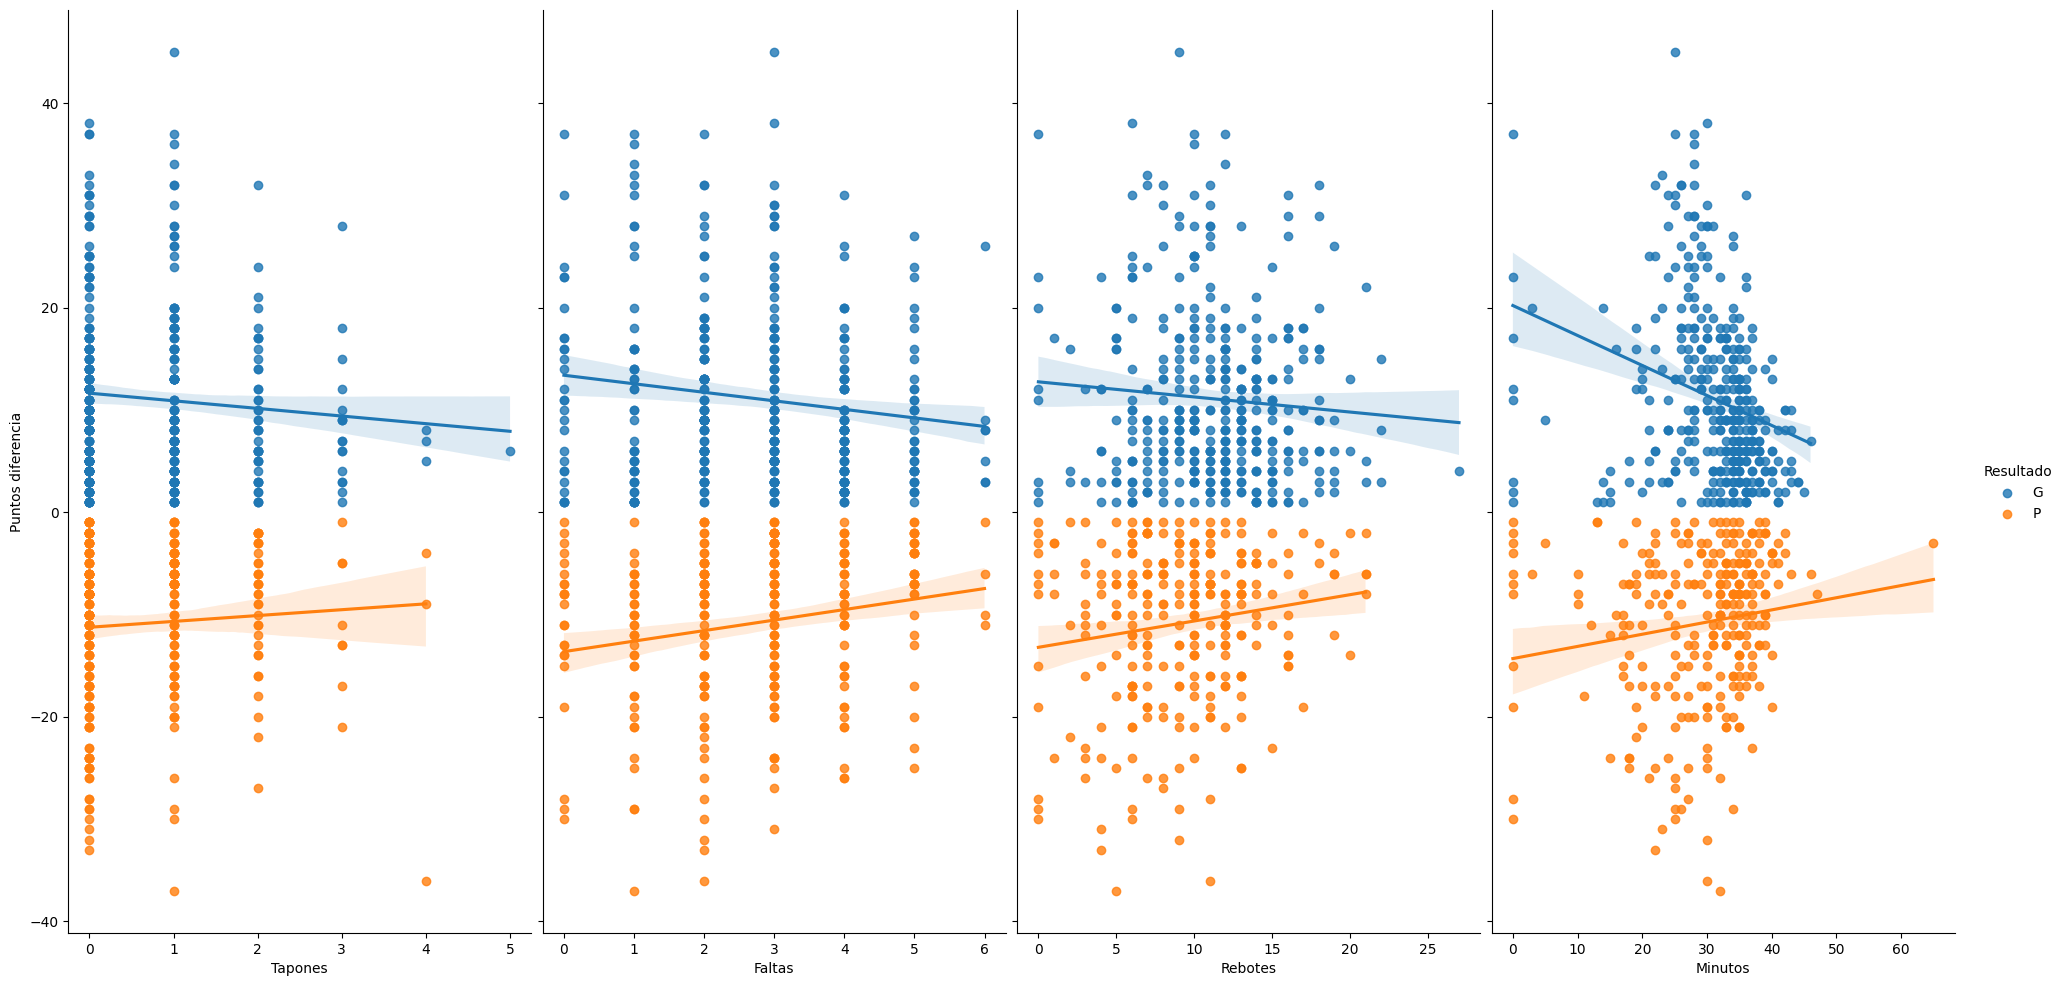

In [162]:
sns.pairplot(df_merge_player_stats, x_vars=['Puntos','Asistencias','Robos','Perdidas'], hue='Resultado', y_vars='Puntos diferencia', kind='reg', height=10, aspect=0.5)
sns.pairplot(df_merge_player_stats, x_vars=['Tapones','Faltas','Rebotes', 'Minutos'], hue='Resultado', y_vars='Puntos diferencia', kind='reg', height=10, aspect=0.5)

#### RELACION ENTRE APARTADOS ESTADISTICOS DIFERENCIANDO ENTRE PARTIDOS GANADOS O PERDIDOS

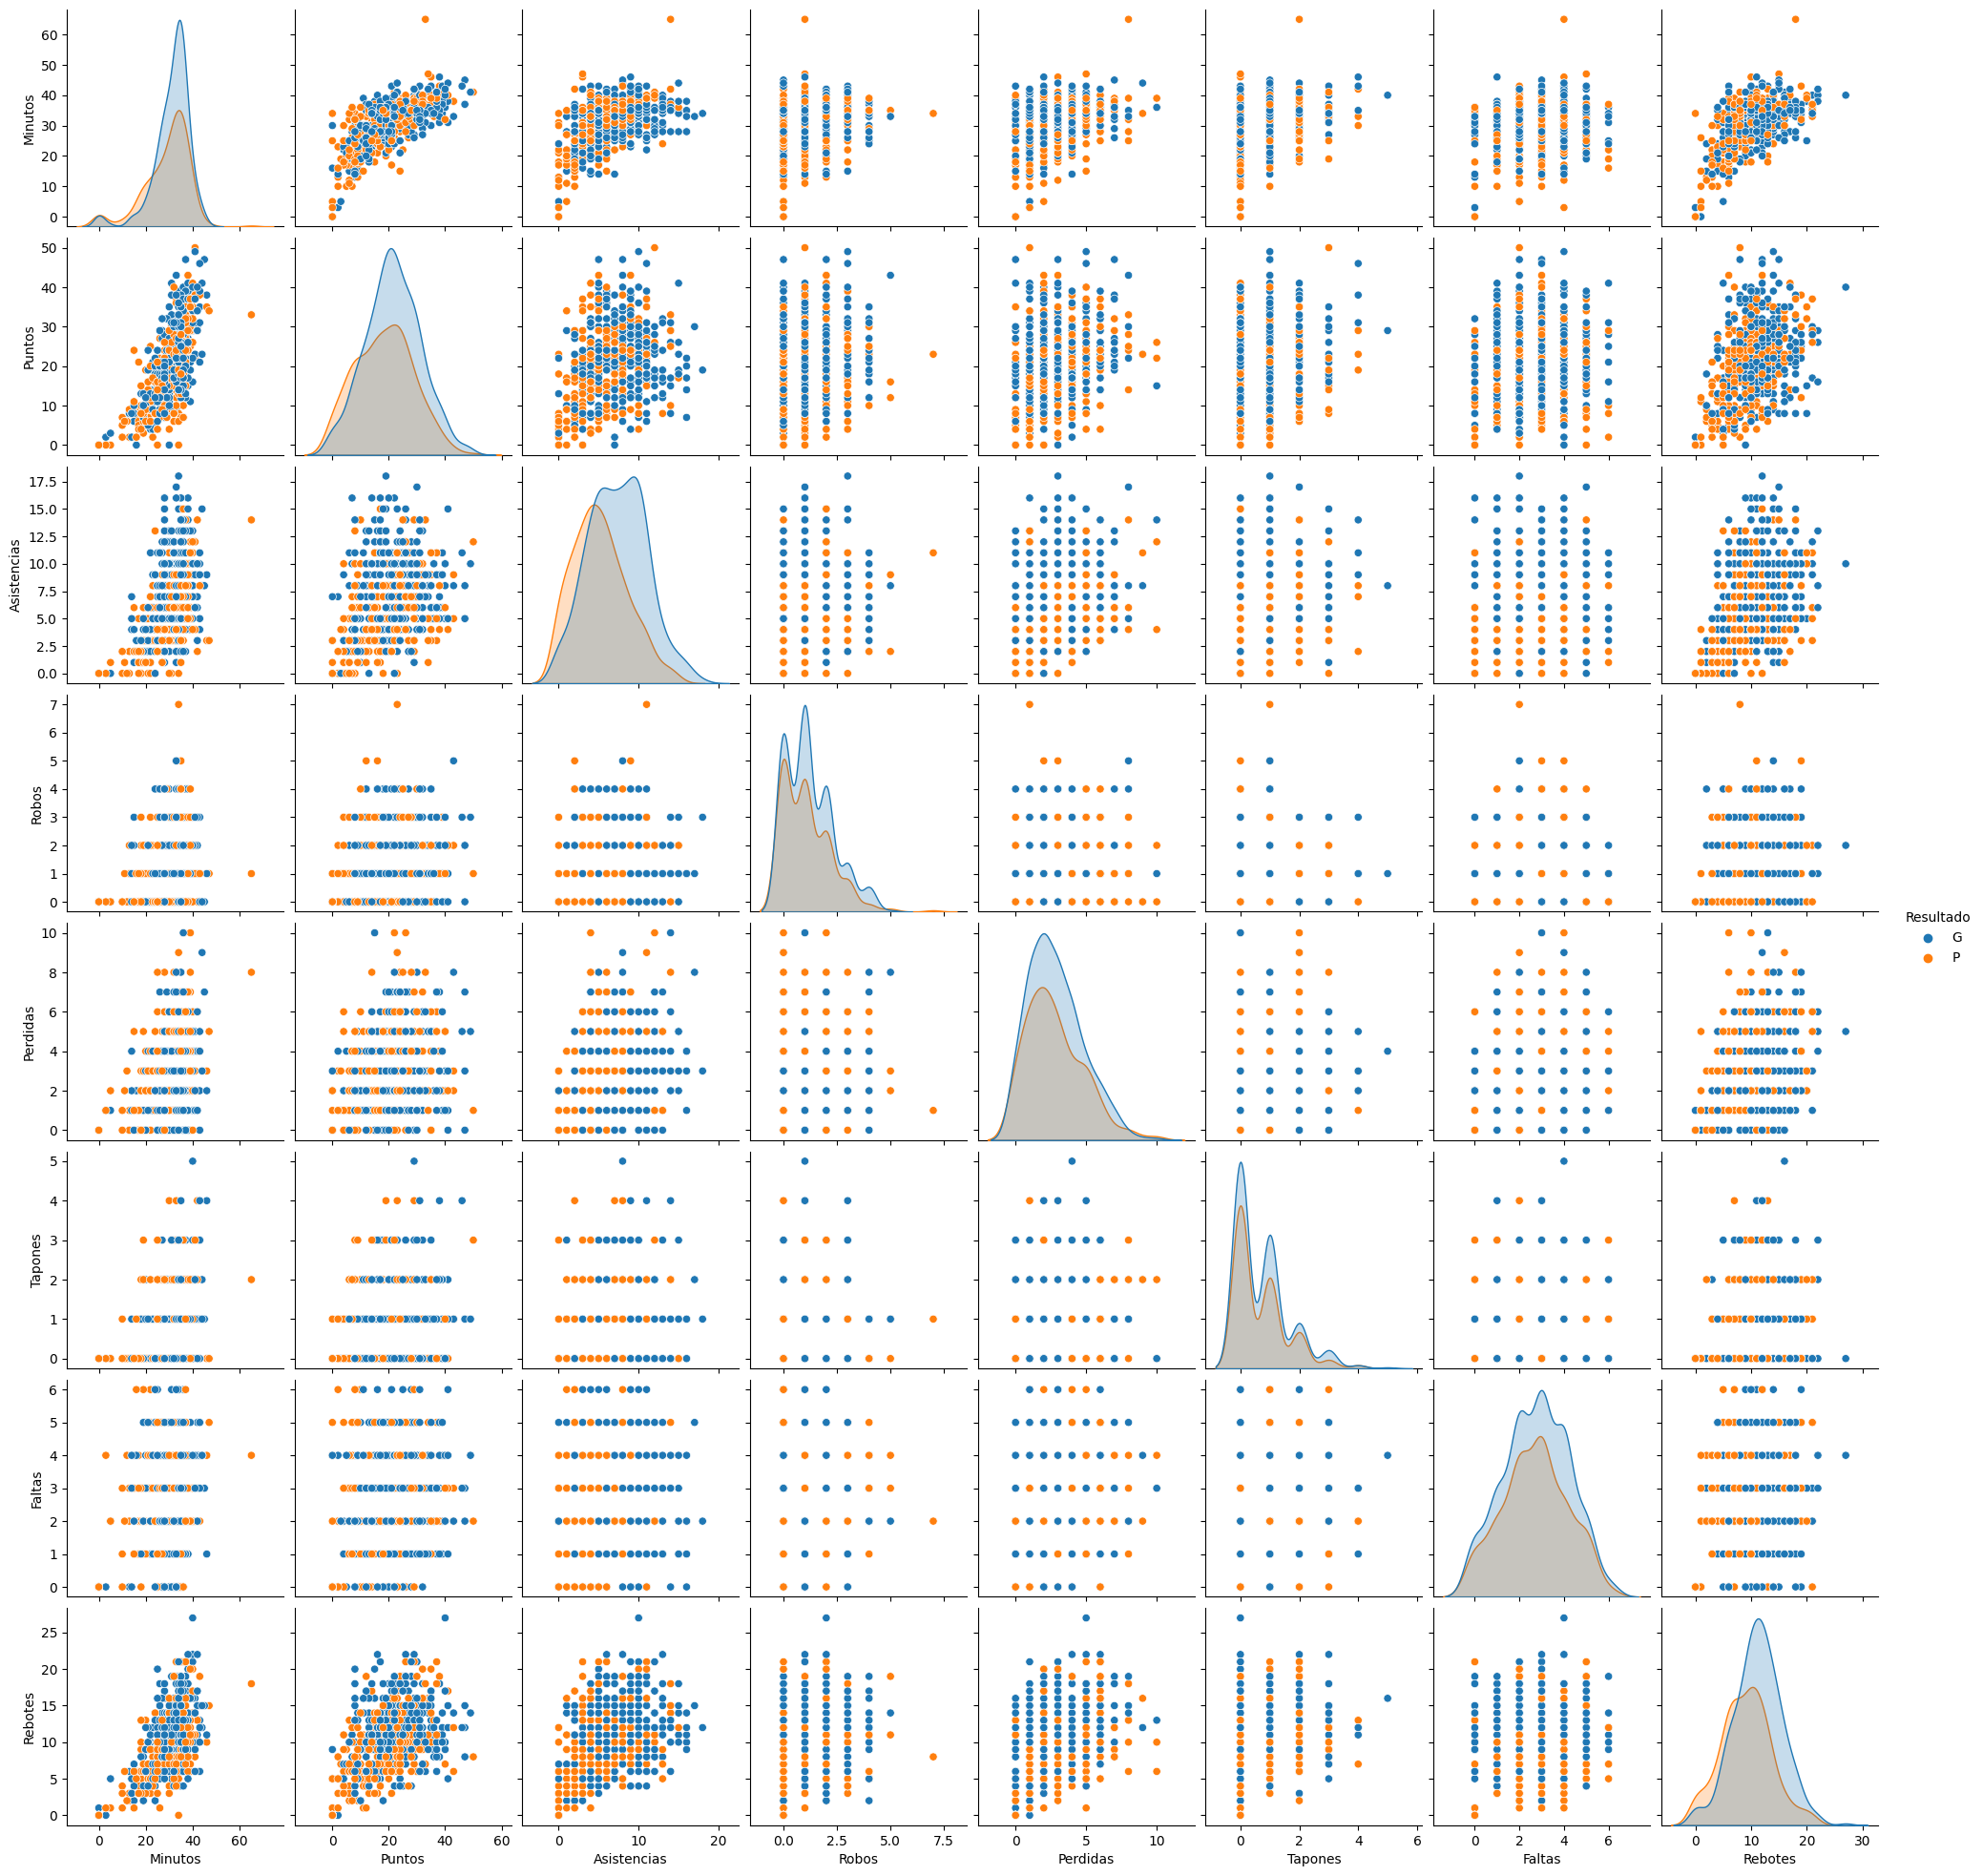

In [163]:
sns.pairplot(df_merge_player_stats, vars=['Minutos', 'Puntos', 'Asistencias', 'Robos', 'Perdidas', 'Tapones', 'Faltas', 'Rebotes'], hue='Resultado')

## CODIFICAMOS NUESTRA COLUMNA RESULTADO

In [164]:
def encode_features(df, features):
    '''
    Funcion para codificar columna result para nuestro modelo
    '''
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        print(f'Feature {feature} OK')

In [165]:
features = ['Resultado']
encode_features(df_merge_player_stats, features)
display(df_merge_player_stats.sample(5))

Feature Resultado OK


,Minutos,Puntos,Asistencias,Robos,Perdidas,Tapones,Faltas,Rebotes,Resultado,Puntos diferencia
537,28.0,20,7,0,3,2,2,8,0,32.0
285,33.0,25,10,1,2,1,3,14,1,-5.0
197,21.0,14,5,2,1,1,4,7,1,-26.0
69,0.0,0,0,0,0,0,0,0,0,11.0
642,28.0,14,10,0,4,0,2,11,0,21.0


In [166]:
print(df_merge_player_stats['Resultado'].unique())

[0 1]


## SEPARAMOS PARA CLASIFICACION Y PARA REGRESION SOBRE LOS DATOS

In [167]:
feature_cols = ['Minutos', 'Puntos', 'Asistencias', 'Robos', 'Perdidas', 'Tapones', 'Faltas', 'Rebotes']
X_CLASS = df_merge_player_stats[feature_cols]
y_class = df_merge_player_stats['Resultado']

In [168]:
feature_cols = ['Minutos', 'Puntos', 'Asistencias', 'Robos', 'Perdidas', 'Tapones', 'Faltas', 'Rebotes']
X_REG = df_merge_player_stats[feature_cols]
y_reg = df_merge_player_stats['Puntos diferencia']

## BUSCAMOS MODELO CLASIFICACION PARTIDOS GANADOS O PERDIDOS MEDIANTE GRIDSEARCH

#### Modelo KNeighbors

##### Definimos parámetros

In [169]:
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_grid_knn = dict(n_neighbors=k_range, weights=weight_options)
knn = KNeighborsClassifier()
print(param_grid_knn)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}


In [170]:
grid_knn = GridSearchCV(knn, param_grid_knn, cv=10, scoring='accuracy')
grid_knn.fit(X_CLASS, y_class)
print(grid_knn.best_score_)
print(grid_knn.best_params_)

0.6328810492989597
{'n_neighbors': 30, 'weights': 'uniform'}


#### Modelo DecissionTreeClassfier

In [171]:
depth_range = list(range(4, 17, 2))
random_range = list(range(2, 43, 8))
param_grid_dct = dict(max_depth=depth_range, random_state=random_range)
dtc = DecisionTreeClassifier()
print(param_grid_dct)

{'max_depth': [4, 6, 8, 10, 12, 14, 16], 'random_state': [2, 10, 18, 26, 34, 42]}


In [172]:
grid_dtc = GridSearchCV(dtc, param_grid_dct, cv=10, scoring='accuracy')
grid_dtc.fit(X_CLASS, y_class)
print(grid_dtc.best_score_)
print(grid_dtc.best_params_)

0.6042966983265491
{'max_depth': 4, 'random_state': 18}


#### Seleccionamos mejor modelo

In [173]:
if grid_dtc.best_score_ > grid_knn.best_score_:
    best_classifier_model = grid_dtc.best_estimator_
else: best_classifier_model = grid_knn.best_estimator_

print(best_classifier_model)

KNeighborsClassifier(n_neighbors=30)


### No obtenemos buena accuracy porque en el equipo hay más jugadores y no depende solo de que uno tenga ciertas estadísticas para ganar un partido, por lo menos en el caso de los DENVER NUGGETS y NIKOLA JOKIC. Tendríamos que estudiar a más de un jugador relevante al mismo tiempo.

## BUSCAMOS MODELO REGRESION PREDICCION PUNTOS DIFERENCIA

#### Modelo LinearRegression

In [174]:
n_jobs_range = list(range(4, 17, 2))
param_grid_linreg = dict(n_jobs=n_jobs_range)
linreg = LinearRegression()
print(param_grid_linreg)

{'n_jobs': [4, 6, 8, 10, 12, 14, 16]}


In [175]:
grid_linreg = GridSearchCV(linreg, param_grid_linreg, cv=10, scoring='neg_root_mean_squared_error')
grid_linreg.fit(X_REG, y_reg)
print(grid_linreg.best_score_)
print(grid_linreg.best_params_)

-12.596097045497048
{'n_jobs': 4}


#### Modelo DecisionTreeRegressor

In [176]:
depth_range = list(range(4, 17, 2))
random_range = list(range(2, 43, 8))
param_grid_dtr = dict(max_depth=depth_range, random_state=random_range)
dtr = DecisionTreeRegressor()
print(param_grid_dtr)

{'max_depth': [4, 6, 8, 10, 12, 14, 16], 'random_state': [2, 10, 18, 26, 34, 42]}


In [177]:
grid_dtr = GridSearchCV(dtr, param_grid_dtr, cv=10, scoring='neg_root_mean_squared_error')
grid_dtr.fit(X_REG, y_reg)
print(grid_dtr.best_score_)
print(grid_dtr.best_params_)

-13.264272691529134
{'max_depth': 4, 'random_state': 10}


#### Seleccionamos mejor modelo

In [178]:
if grid_dtr.best_score_ > grid_linreg.best_score_:
    best_regression_model = grid_dtr.best_estimator_
else: best_regression_model = grid_linreg.best_estimator_

print(best_regression_model)

LinearRegression(n_jobs=4)


### Aquí nos pasa lo mismo que antes, tendríamos que estudiar a varios jugadores juntos para establecer unas mejores relaciones y así obtener mejores modelos, más precisos en su predicción. En este caso tenemos un error de -12 puntos de predicción sobre lo que saldría.